# Visión por Computadora I - 2025 - B3 - Trabajo práctico 2
**Inteligencia Artificial - CEIA - FIUBA**

## Autores

- **Mealla Pablo**.
- **Mendoza Dante**.
- **Vasquez Jorge**.
- **Viñas Gustavo**.

# 💻 TP2 - Objetivo

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas.  
El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Área de la ROI = 5 o 10% del área total del frame.
    3. (Opcional) Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc… (al menos 3)  
  
    Para cada experimento se debe presentar :
      - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shape from focus.  
3. (Puntos extra) Aplicar unsharp masking para expandir la zona de enfoque y recalcular la métrica.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### 1. Implementación del algoritmo

In [2]:
def image_quality_measure(I: np.ndarray) -> float:
    """
    Calculate image quality measure

    Parameters
    ---------
    I (np.ndarray)
        Source image
    
    Returns
    ---------
    FM (float)
        Image Quality Measure for input image
    """
    if (I.ndim != 2): raise Exception("Only 2D (gray) images allowed.")
    # step 1 - compute fast fourier transform (fft) representation of source image
    F = np.fft.fft2(I)
    # step 2 - shift origin of fft to centre
    Fc = np.fft.fftshift(F)
    # step 3 - calculate absolute value of the centered fft
    AF = np.abs(Fc)
    # step 4 - calculate max value of absolute fft
    M = np.max(AF)
    # step 5 - calculate threshold and total number of pixels in fft image whose pixel value is above threshold
    thres = M / 1000
    T_h = sum(1 for p in AF.ravel() if p > thres) ## Duda si aca va AF o F (según el paper indica F, pero nos hace mas sentido que sea AF). (Según pruebas sobre lena, sería AF)
    FM = T_h / (I.shape[0] * I.shape[1])
    return FM

In [3]:
# Test algorithm 
img_lena = cv2.imread('./img/lena_std.tif', cv2.IMREAD_GRAYSCALE)
print(f"Lena IQM (FM): {image_quality_measure(img_lena):.4f}")


Lena IQM (FM): 0.0182


Funciones para el procesamiento del video y gráfico

In [4]:
from collections.abc import Callable
def process_video(video_path: str, frame_func, **kwargs) -> list[float]:
    """
    Abre y recorre un video frame por frame, invocando a la funcion frame_func por cada frame.
    Guarda el resultado de frame_func en un array que es retornado como resultado

    Parameters
    ---------
    video_path (str)
        Ruta al video
    frame_func (Callable[[np.ndarray], float])
        Función que se invoca por cada frame.
        Debe aceptar la imagen del frame como np.ndarray.
        Debe retornar el valor del procesamiento del frame como float.
    
    Returns
    ---------
    (list[float])
        Array de resultados obtenidos por el procesamiento de cada frame
    """
    video = cv2.VideoCapture(video_path)
    if not video.isOpened(): raise Exception("Error al abrir el archivo de video")

    try:
        res_array = []
        while True:
            ret, frame = video.read()
            if not ret: break
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            single_frame_res = frame_func(frame_gris, **kwargs)
            res_array.append(single_frame_res)
        
        return res_array
    finally:
        video.release()

def plot_comparative(elements: list[list[float]], labels: list[str], figsize: list[int], colors: list[str]) -> None:
    """
    Función auxiliar para graficar varios arrays uno al lado del otro y una comparativa de todos debajo.

    Parameters
    ---------
    elements (list[list[float]])
        Lista de arrays que se graficarán
    labels (list[str])
        Lista de labels para cada array.
    figsize (list[int])
        Tamaño del gráfico completo.
    colors (list[str])
        Colores aplicados a cada array graficado.
    """
    plt.figure(figsize=figsize)
    axn=plt.subplot(212)
    for x in range(len(elements)):
        ax=plt.subplot(200 + len(elements) * 10 + x + 1)
        ax.plot(elements[x], marker='o', linestyle='', color=colors[x])
        max_frame = int(np.argmax(elements[x]))
        ax.axvline(max_frame, color=colors[x])
        ax.text(max_frame, ax.get_ylim()[0], str(max_frame))
        ax.text(max_frame, elements[x][max_frame], f"{elements[x][max_frame]:.3f}")
        ax.set_xlabel("Frame #")
        ax.set_ylabel("IQM (FM)")
        ax.set_title(label=labels[x])
        ax.grid(True)

        axn.plot(elements[x], marker='o', linestyle='', color=colors[x], label=labels[x])
        axn.axvline(max_frame, color=colors[x])
        axn.text(max_frame, axn.get_ylim()[0], str(max_frame))
        axn.text(max_frame, elements[x][max_frame], f"{elements[x][max_frame]:.3f}")
    axn.set_xlabel("Frame #")
    axn.set_ylabel("IQM (FM)")
    axn.set_title(r"ROI comparative")
    axn.legend()
    axn.grid(True)

>  1. Medición sobre todo el frame

In [5]:
def full_frame_analysis(frame: np.ndarray, measure_func) -> float:
    """
    Funcion que analiza el frame completo con el algoritmo measure_func.

    Parameters
    ---------
    frame (np.ndarray)
        Frame que se analizará.
    
    Returns
    ---------
    (float)
        Resultado del analisis del frame
    """
    return measure_func(frame)

In [6]:
video_path = "./video/focus_video.mov"
full_frame_iqm = process_video(video_path, full_frame_analysis, measure_func=image_quality_measure)

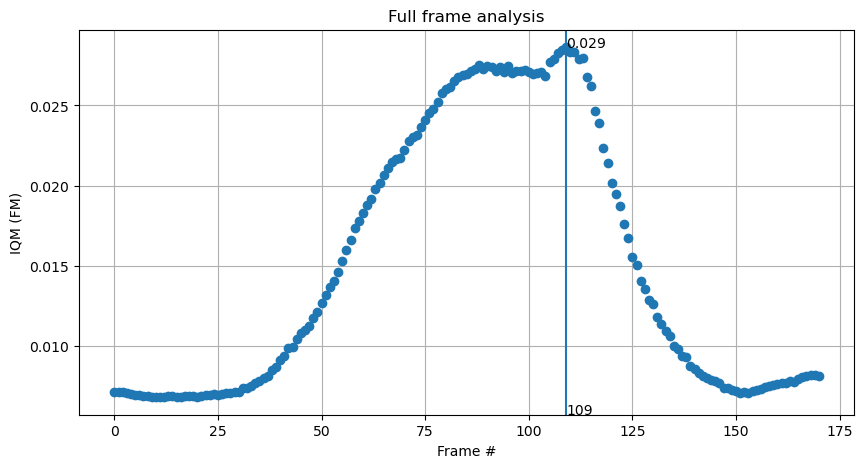

In [7]:
plt.figure(figsize=(10,5))
plt.plot(full_frame_iqm, marker='o', linestyle='')
max_frame = int(np.argmax(full_frame_iqm))
plt.axvline(max_frame)
plt.text(max_frame, plt.ylim()[0], str(max_frame))
plt.text(max_frame, full_frame_iqm[max_frame], f"{full_frame_iqm[max_frame]:.3f}")
plt.xlabel("Frame #")
plt.ylabel("IQM (FM)")
plt.title("Full frame analysis")
plt.grid(True)
plt.show()

>  2. Medición sobre una ROI centrada de 10% y 5%

In [8]:
def roi_frame_analysis(frame: np.ndarray, roi: float, measure_func) -> float:
    """
    Funcion que analiza el frame con el algoritmo measure_func
    utilizando solo la región central definida por el % de ROI sobre 
    el área total de la imagen.

    Parameters
    ---------
    frame (np.ndarray)
        Frame que se analizará.
    roi (float)
        Porcentaje del área de imagen que se analizará, establecida en 1/100.
    
    Returns
    ---------
    (float)
        Resultado del analisis del frame
    """
    if roi > 1 or roi <= 0: raise Exception("roi value must be greater than 0 and less than 1")
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    roi_x_size = roi_y_size = np.sqrt(frame_height * frame_width * roi)

    # Si el ROI desborda en algún sentido, compenzo el área sobrante hacia el otro eje.
    # Esto puede ocurrir porque el ROI se asume cuadrado y centrado.
    # Es una decisión de diseño, podría simplemente limitarse o lanzar error.
    # O podría considerarse el ROI como porcentaje sobre cada lado (aunque asi no 
    # representaría el % sobre el área total del frame)
    if (roi_x_size > frame_width):
        roi_y_size += (roi_x_size - frame_width) * roi_y_size / frame_width
        roi_x_size = frame_width
    if (roi_y_size > frame_height):
        roi_x_size += (roi_y_size - frame_height) * roi_x_size / frame_height
        roi_y_size = frame_height

    roi_x_size = int(roi_x_size)
    roi_y_size = int(roi_y_size)
    roi_x = frame_width // 2 - roi_x_size // 2
    roi_y = frame_height // 2 - roi_y_size // 2
    return measure_func(frame[roi_y:roi_y+roi_y_size,roi_x:roi_x+roi_x_size])

In [9]:
roi_frame_iqm = []
video_path = "./video/focus_video.mov"
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=0.1, measure_func=image_quality_measure))
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=0.05, measure_func=image_quality_measure))
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=1, measure_func=image_quality_measure)) # Debe dar el mismo resultado que el punto 1 por el ajuste sobre el desborde

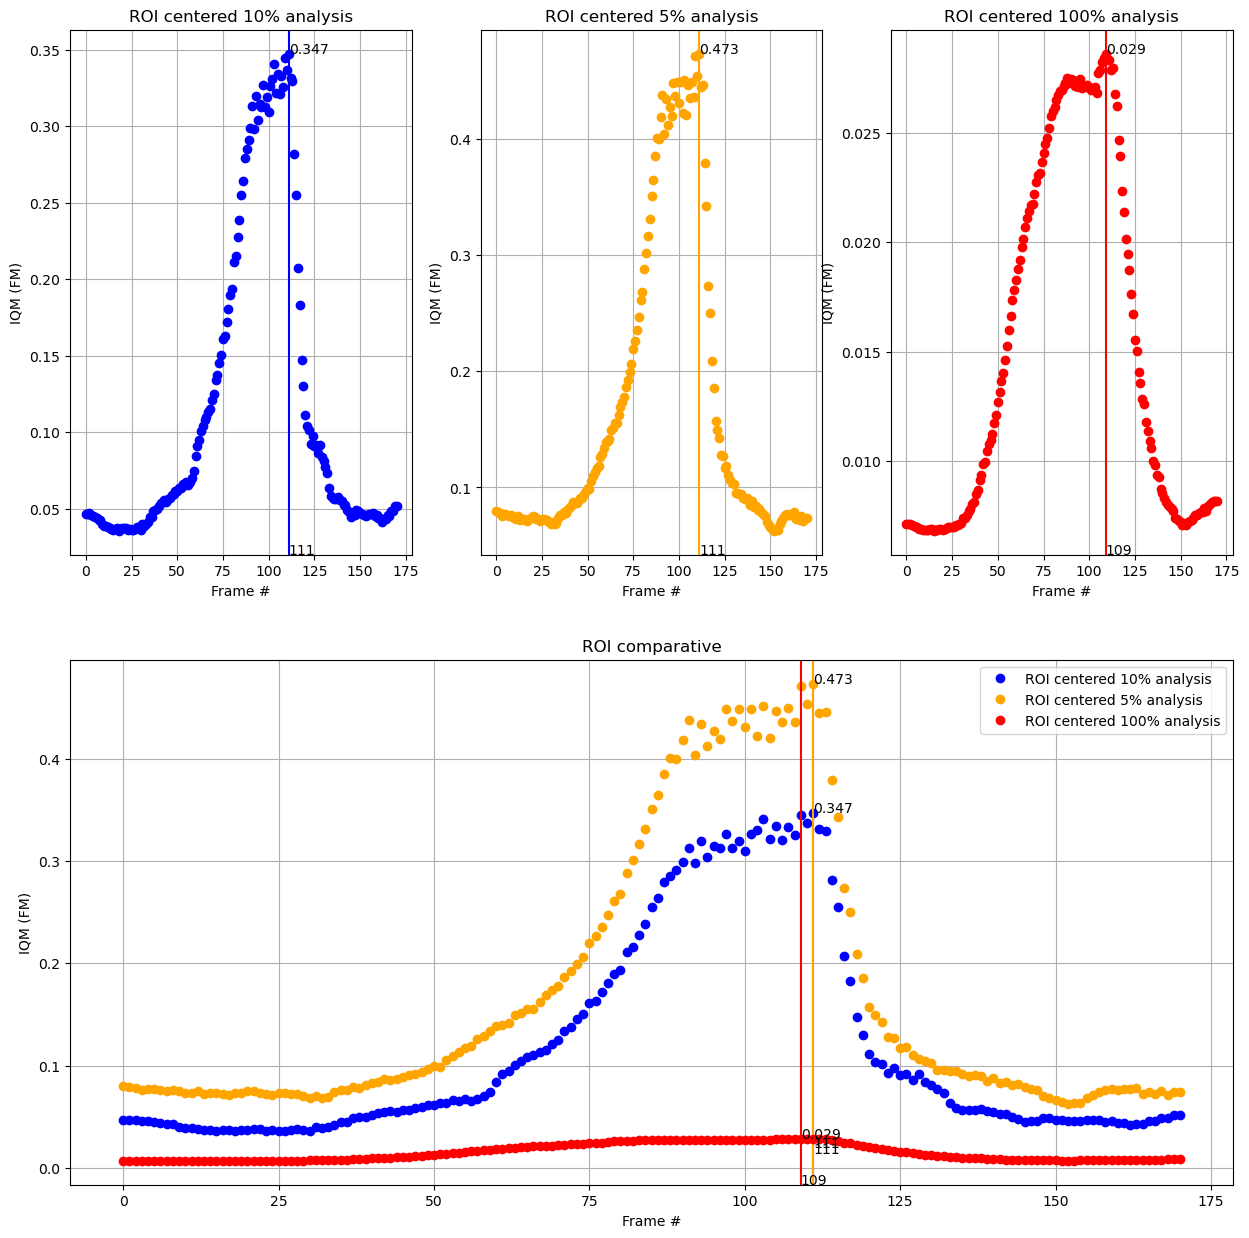

In [10]:
colors = ["blue", "orange", "red"]
plot_comparative(roi_frame_iqm, [r"ROI centered 10% analysis", r"ROI centered 5% analysis", r"ROI centered 100% analysis"], [15,15], colors)

>  3. Medición sobre una matriz de enfoque de NxM

In [11]:
video_path = "./video/focus_video.mov"

def matrix_frame_analysis(frame: np.ndarray, matrix_n: int, matrix_m: int, box_width_px: int, box_height_px: int, space_px: int, measure_func) -> float:
    """
    Funcion que analiza el frame con el algoritmo measure_func
    utilizando una matriz de NxM con áreas rectangulares de box_width_px x 
    box_height_px separadas equidistantes por space_px pixeles.

    Parameters
    ---------
    frame (np.ndarray)
        Frame que se analizará.
    matrix_n (int)
        Cantidad de áreas que se analizarán a lo ancho (N).
    matrix_m (int)
        Cantidad de áreas que se analizarán a lo alto (M).
    box_width_px (int)
        Ancho de las áreas que se analizaran, en pixeles.
    box_height_px (int)
        Alto de las áreas que se analizaran, en pixeles.
    space_px (int)
        Espacio de separación para las áreas, en pixeles.
    
    Returns
    ---------
    (float)
        Resultado del analisis del frame
    """
    if matrix_n < 1 or matrix_m < 1: raise Exception("m and n must be greater or equal than 1")
    if box_width_px < 1: raise Exception("box_width_px value must be greater than 0")
    if box_height_px < 1: raise Exception("box_height_px value must be greater than 0")
    if space_px < 1: raise Exception("space_px value must be greater than 0")

    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    roi_size_n = box_width_px * matrix_n
    space_size_n = space_px * (matrix_n - 1)
    roi_size_m = box_height_px * matrix_m
    space_size_m = space_px * (matrix_m - 1)

    # En este caso, si los ROIs sumados a los espacios exceden los límites del frame, lanzamos error.
    if (roi_size_n + space_size_n) > frame_width: raise Exception("Sum of roi sizes and space sizes exceed frame width")
    if (roi_size_m + space_size_m) > frame_height: raise Exception("Sum of roi sizes and space sizes exceed frame height")

    start_x = frame_width // 2 - roi_size_n // 2 - space_size_n // 2
    start_y = frame_height // 2 - roi_size_m // 2 - space_size_m // 2

    frame_iqm = []
    for n in range(matrix_n):
        x = start_x + n * (box_width_px + space_px)
        for m in range(matrix_m):
            y = start_y + m * space_px
            frame_iqm.append(measure_func(frame[y:y+box_height_px,x:x+box_width_px]))
    
    return float(np.mean(frame_iqm))

In [12]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=151, 
                                      box_height_px=151, space_px=20, measure_func=image_quality_measure)) # Debe dar el resultado del punto 2 para roi 0.1
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=107, 
                                      box_height_px=107, space_px=20, measure_func=image_quality_measure)) # Debe dar el resultado del punto 2 para roi 0.05
# El gráfico obtenido debería ser igual al punto anterior para los casos 10% y 5%. Hecho solo para verificación.

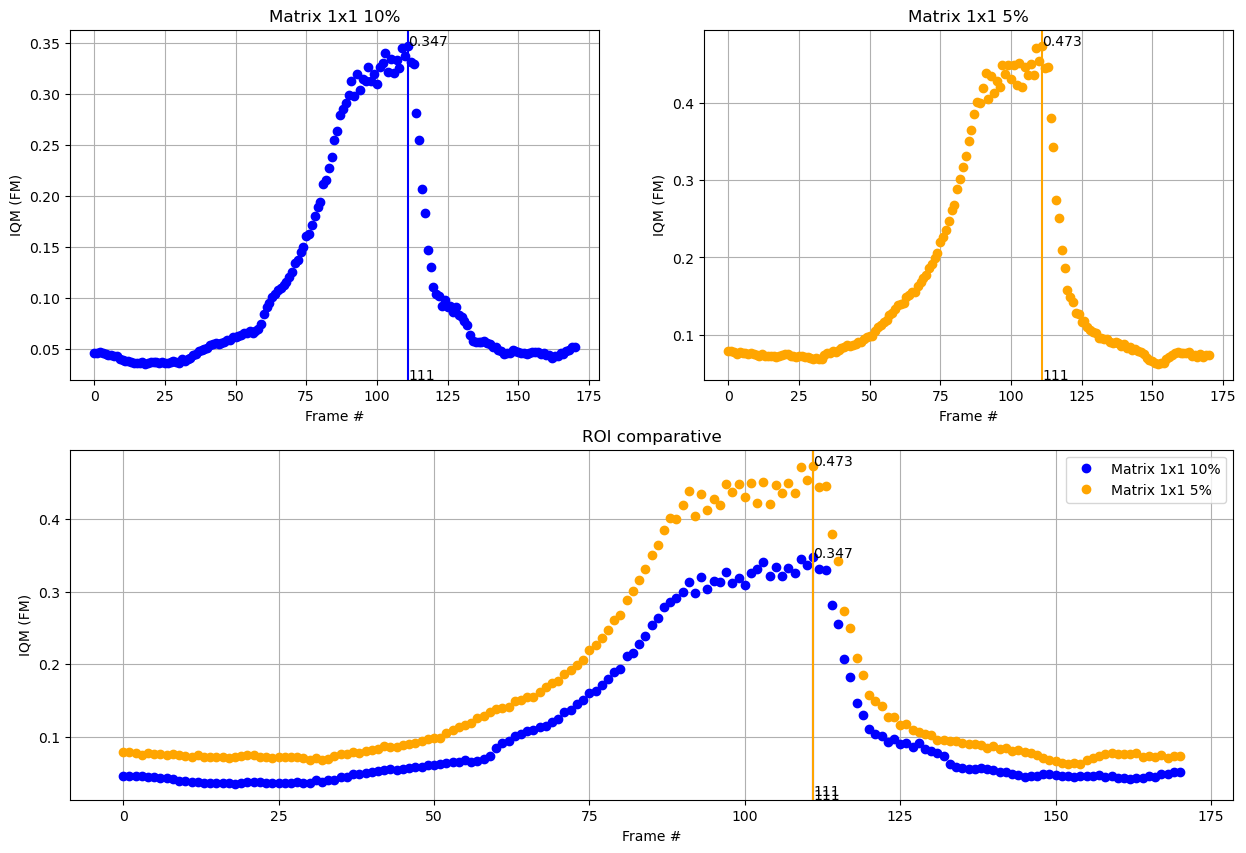

In [13]:
colors = ["blue", "orange"]
plot_comparative(matrix_frame_iqm, [r"Matrix 1x1 10%", r"Matrix 1x1 5%"], [15,10], colors)


#### Probamos otros casos

In [14]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=5, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=image_quality_measure))


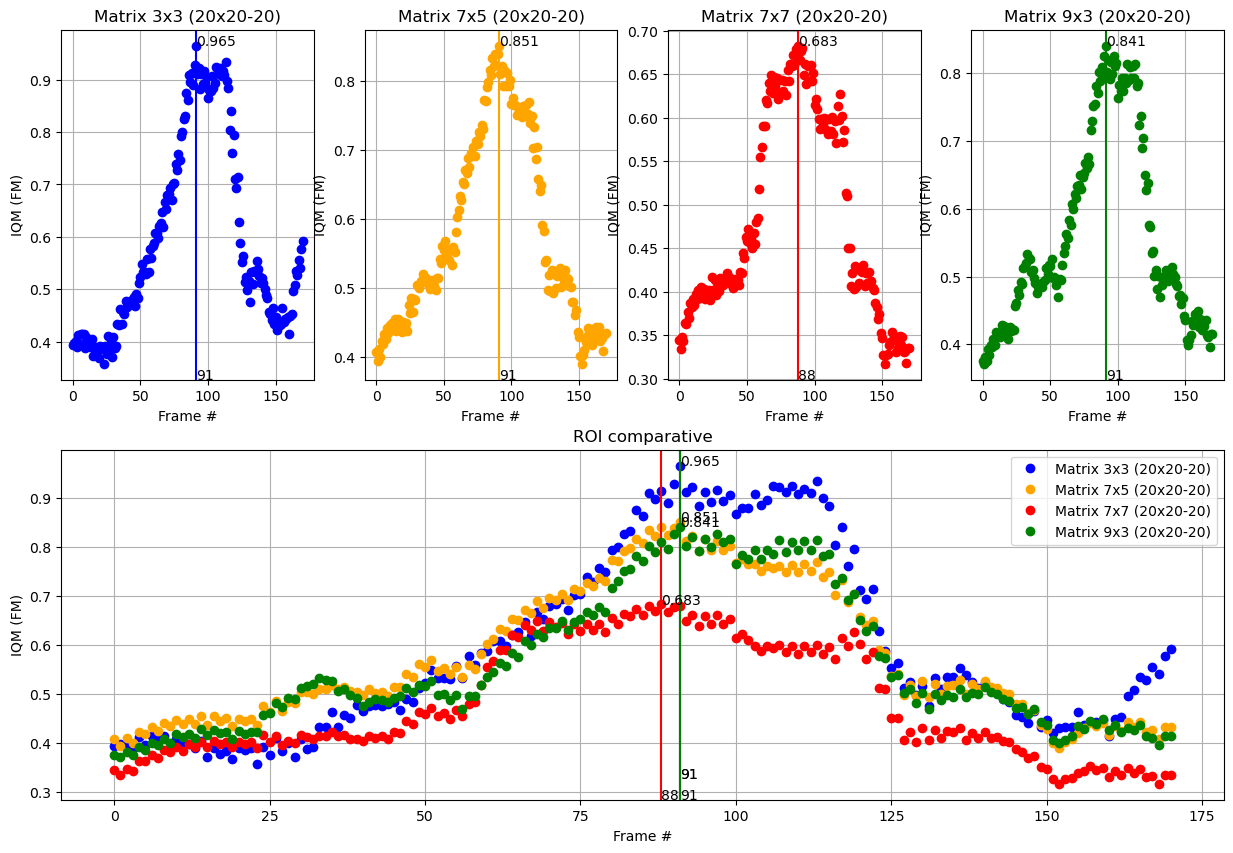

In [15]:
colors = ["blue", "orange", "red", "green"]
plot_comparative(matrix_frame_iqm, [r"Matrix 3x3 (20x20-20)", r"Matrix 7x5 (20x20-20)", r"Matrix 7x7 (20x20-20)", r"Matrix 9x3 (20x20-20)"], [15,10], colors)

#### Y algunos mas

In [16]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=3, box_width_px=40, box_height_px=20, space_px=30, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=1, box_width_px=20, box_height_px=40, space_px=30, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=10, box_height_px=10, space_px=30, measure_func=image_quality_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=30, box_height_px=30, space_px=10, measure_func=image_quality_measure))

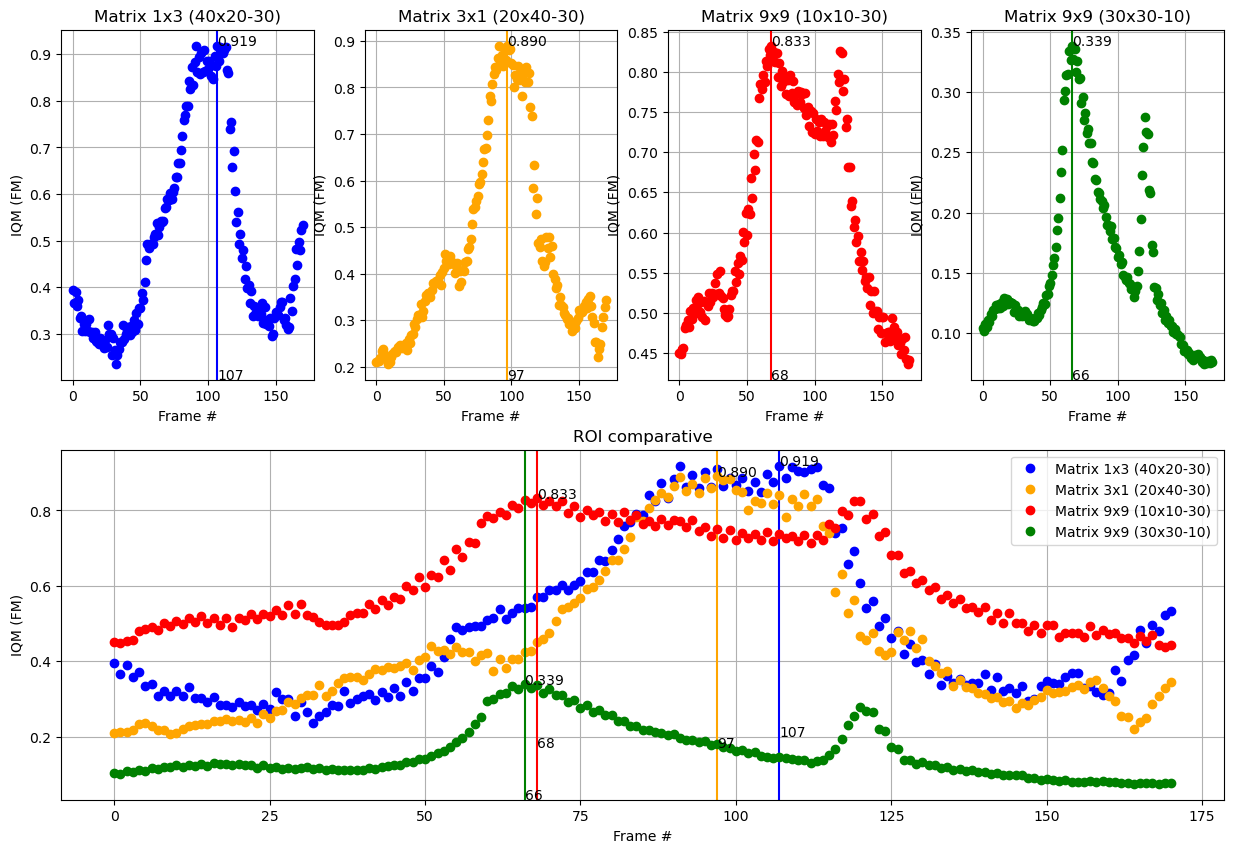

In [17]:
colors = ["blue", "orange", "red", "green"]
plot_comparative(matrix_frame_iqm, [r"Matrix 1x3 (40x20-30)", r"Matrix 3x1 (20x40-30)", r"Matrix 9x9 (10x10-30)", r"Matrix 9x9 (30x30-10)"], [15,10], colors)

## 2. Métricas usando Histogram entropy (STA7)

In [18]:
def sta7_measure(gray_image: np.ndarray) -> float:
    """
    Calculate Histogram entropy (STA7) measure

    Parameters
    ---------
    I (np.ndarray)
        Source image
    
    Returns
    ---------
    FM (float)
        Histogram entropy (STA7) measure for input image
    """
    if (gray_image.ndim != 2): raise Exception("Only 2D (gray) images allowed.")

    hist,_ = np.histogram(gray_image.ravel(),256,(0,256))
    hist = hist / hist.sum()
    res = 0
    for Pk in hist:
        if (Pk != 0):
            res += Pk*np.log(Pk)
    return -res

In [19]:
# Test algorithm 
img_lena = cv2.imread('./img/lena_std.tif', cv2.IMREAD_GRAYSCALE)
print(f"Lena Histogram entropy (STA7): {sta7_measure(img_lena):.4f}")

Lena Histogram entropy (STA7): 5.1605


In [20]:
video_path = "./video/focus_video.mov"
full_frame_iqm = process_video(video_path, full_frame_analysis, measure_func=sta7_measure)

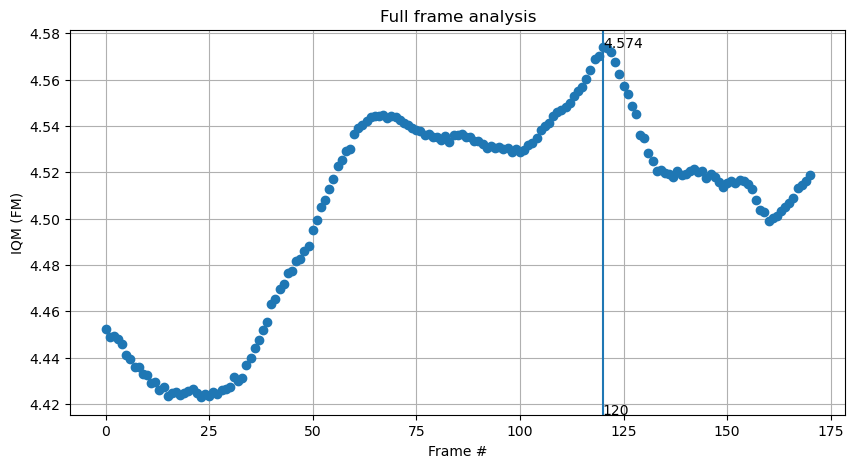

In [21]:
plt.figure(figsize=(10,5))
plt.plot(full_frame_iqm, marker='o', linestyle='')
max_frame = int(np.argmax(full_frame_iqm))
plt.axvline(max_frame)
plt.text(max_frame, plt.ylim()[0], str(max_frame))
plt.text(max_frame, full_frame_iqm[max_frame], f"{full_frame_iqm[max_frame]:.3f}")
plt.xlabel("Frame #")
plt.ylabel("IQM (FM)")
plt.title("Full frame analysis")
plt.grid(True)
plt.show()

In [22]:
roi_frame_iqm = []
video_path = "./video/focus_video.mov"
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=0.1, measure_func=sta7_measure))
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=0.05, measure_func=sta7_measure))
roi_frame_iqm.append(process_video(video_path, roi_frame_analysis, roi=1, measure_func=sta7_measure)) # Debe dar el mismo resultado que el punto 1 por el ajuste sobre el desborde

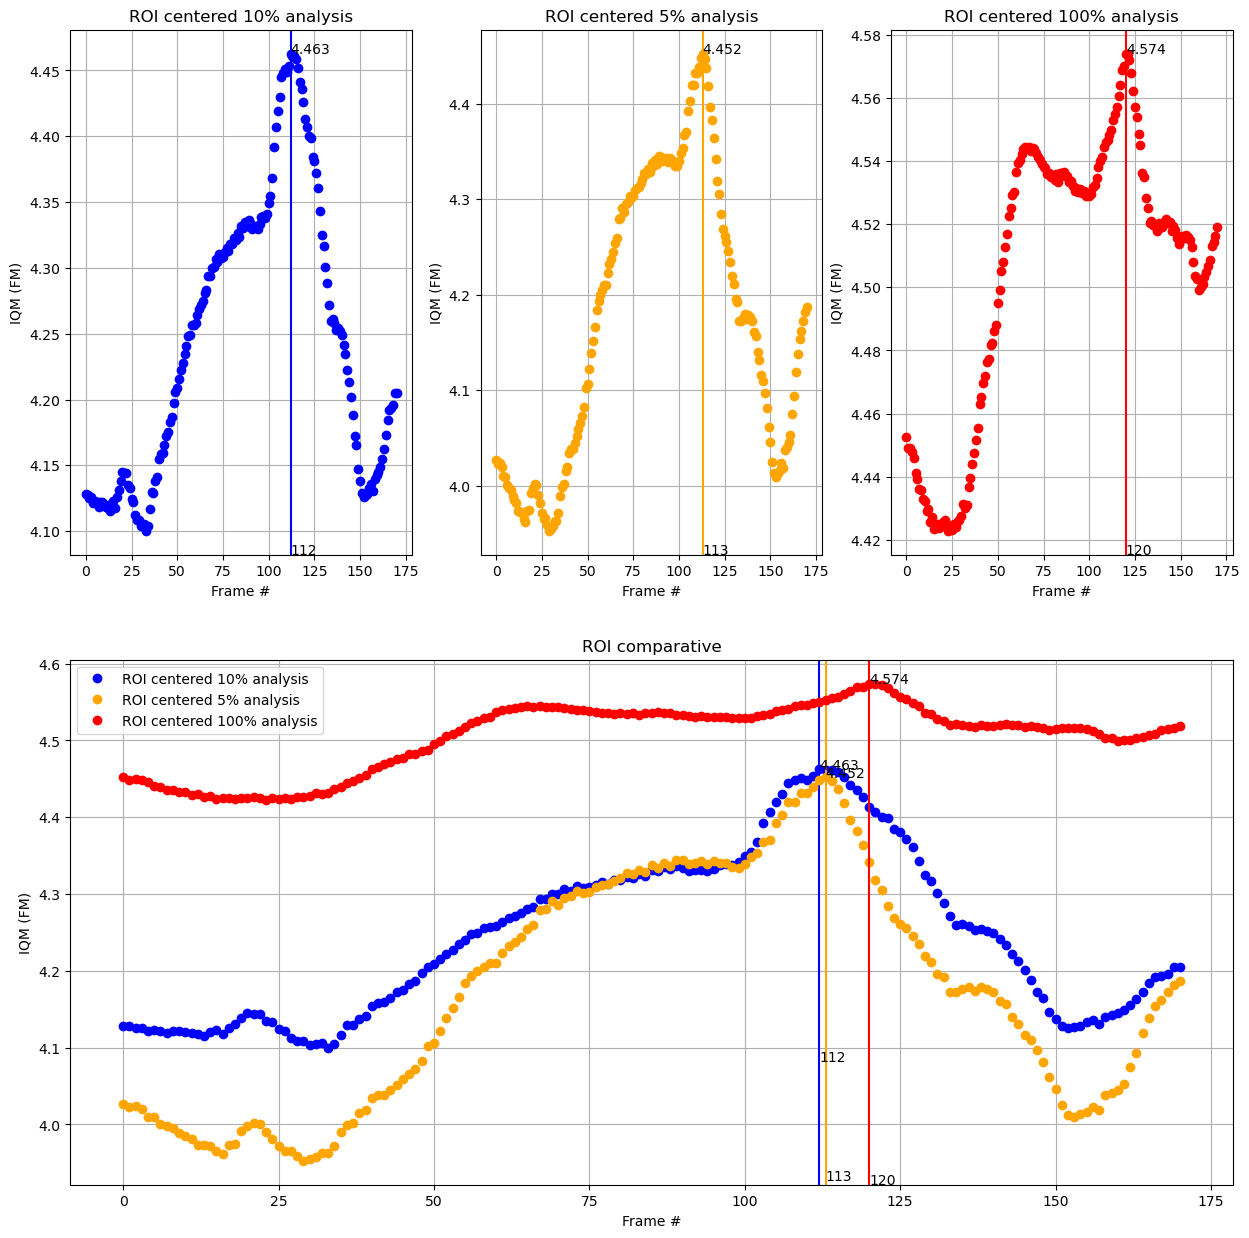

In [23]:
colors = ["blue", "orange", "red"]
plot_comparative(roi_frame_iqm, [r"ROI centered 10% analysis", r"ROI centered 5% analysis", r"ROI centered 100% analysis"], [15,15], colors)

In [24]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=151, 
                                      box_height_px=151, space_px=20, measure_func=sta7_measure)) # Debe dar el resultado del punto 2 para roi 0.1
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=1, box_width_px=107, 
                                      box_height_px=107, space_px=20, measure_func=sta7_measure)) # Debe dar el resultado del punto 2 para roi 0.05
# El gráfico obtenido debería ser igual al punto anterior para los casos 10% y 5%. Hecho solo para verificación.

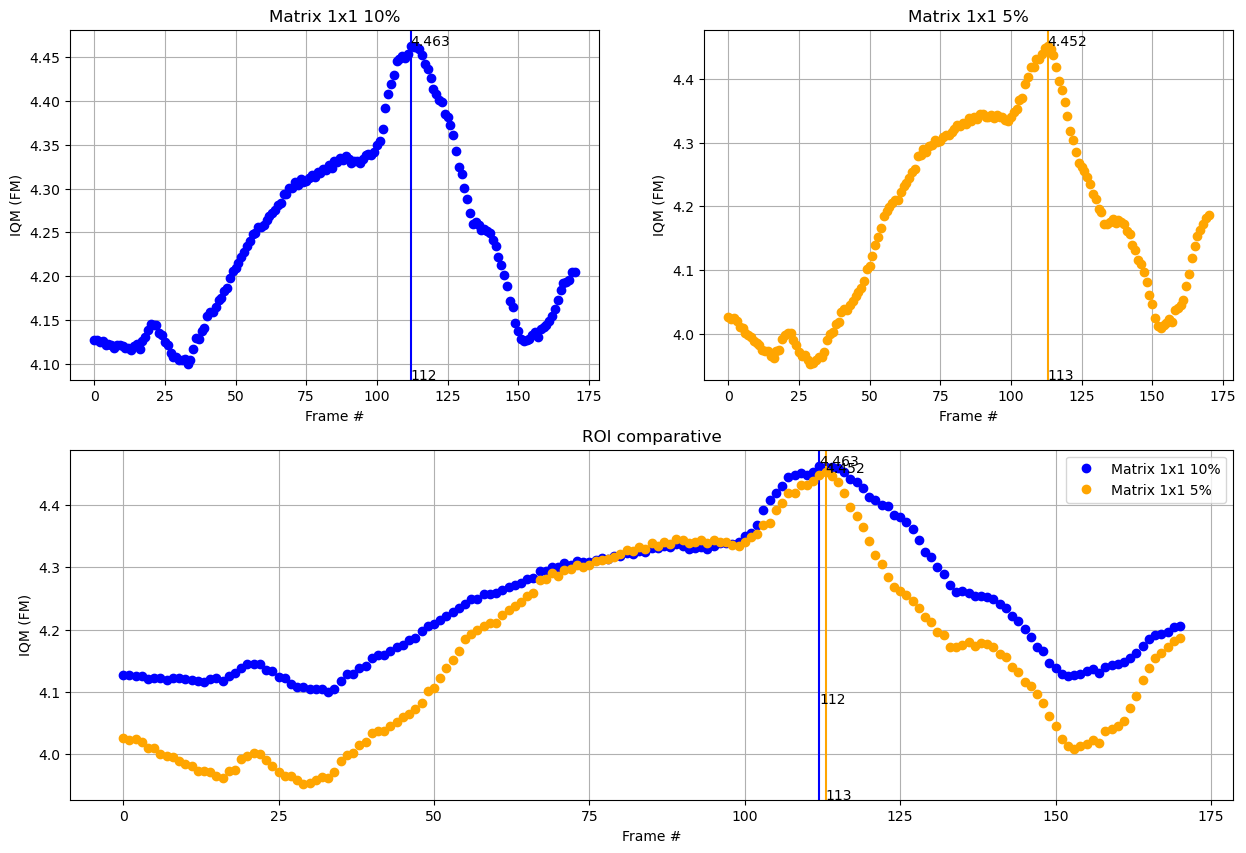

In [25]:
colors = ["blue", "orange"]
plot_comparative(matrix_frame_iqm, [r"Matrix 1x1 10%", r"Matrix 1x1 5%"], [15,10], colors)

In [26]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=5, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=7, matrix_m=7, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=3, box_width_px=20, box_height_px=20, space_px=20, measure_func=sta7_measure))

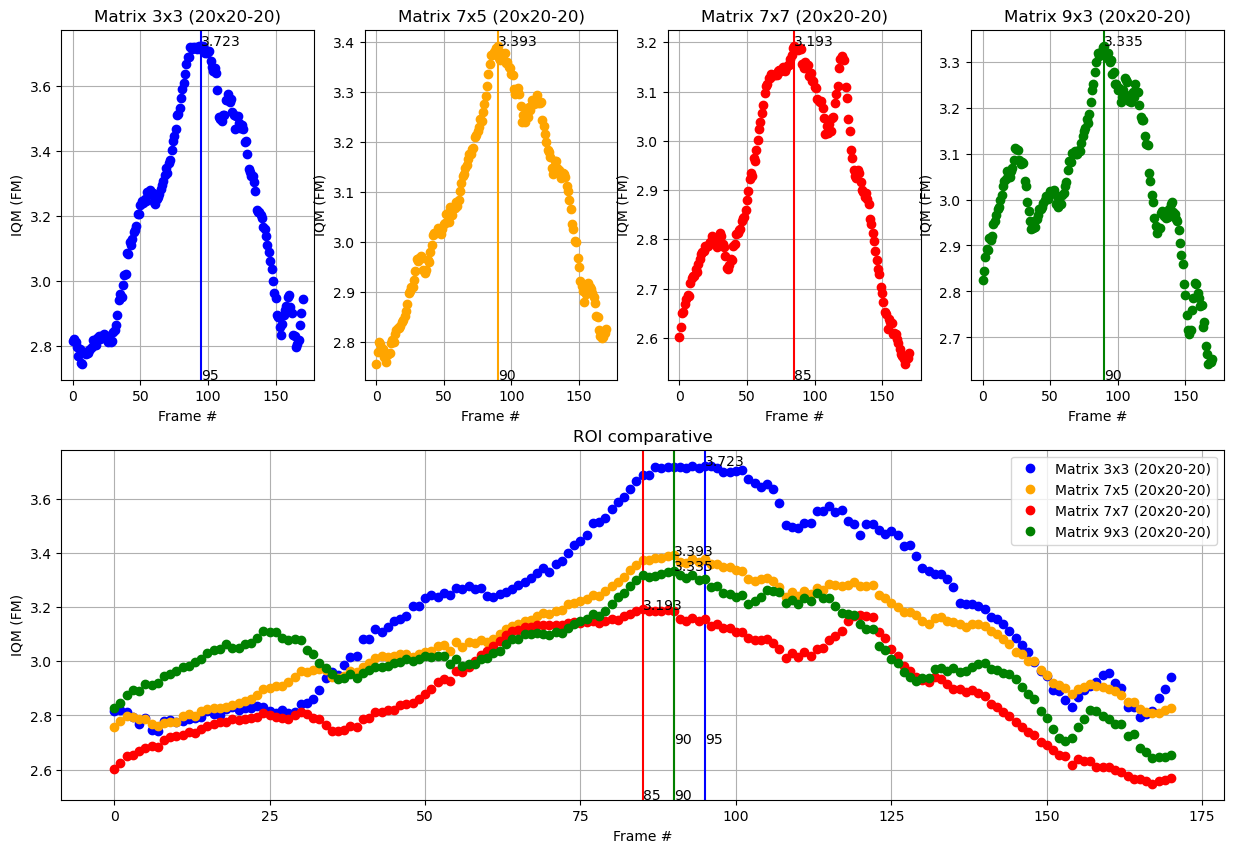

In [27]:
colors = ["blue", "orange", "red", "green"]
plot_comparative(matrix_frame_iqm, [r"Matrix 3x3 (20x20-20)", r"Matrix 7x5 (20x20-20)", r"Matrix 7x7 (20x20-20)", r"Matrix 9x3 (20x20-20)"], [15,10], colors)

In [28]:
matrix_frame_iqm = []
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=1, matrix_m=3, box_width_px=40, box_height_px=20, space_px=30, measure_func=sta7_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=3, matrix_m=1, box_width_px=20, box_height_px=40, space_px=30, measure_func=sta7_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=10, box_height_px=10, space_px=30, measure_func=sta7_measure))
matrix_frame_iqm.append(process_video(video_path, matrix_frame_analysis, matrix_n=9, matrix_m=9, box_width_px=30, box_height_px=30, space_px=10, measure_func=sta7_measure))

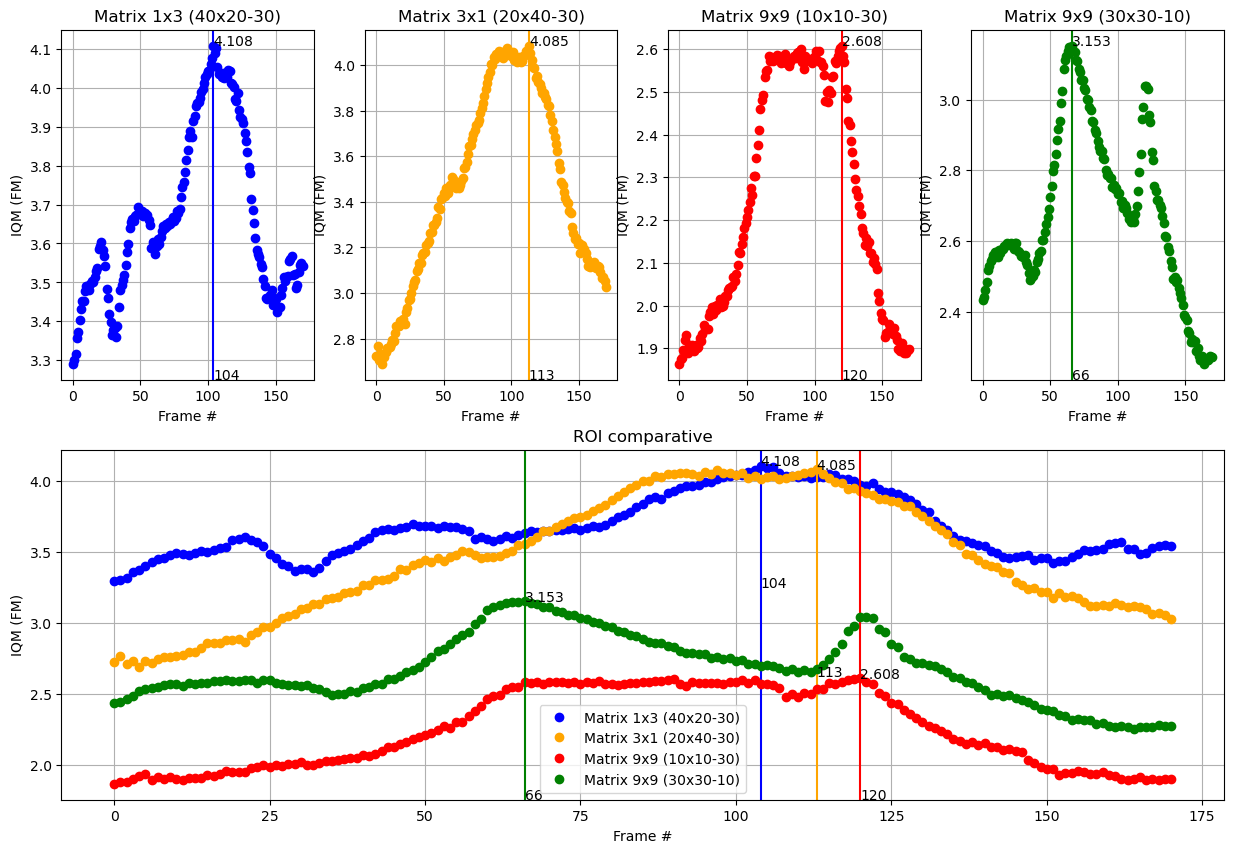

In [29]:
colors = ["blue", "orange", "red", "green"]
plot_comparative(matrix_frame_iqm, [r"Matrix 1x3 (40x20-30)", r"Matrix 3x1 (20x40-30)", r"Matrix 9x9 (10x10-30)", r"Matrix 9x9 (30x30-10)"], [15,10], colors)